# Analysis of Euler's Rigid Body Dynamics using Physics Informed Neural Networks (PINNs)

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import plotly
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

/home/susmit/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning:

Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.



## Euler's Equation for Rigid Body Dynamics

We will use Physics Informed Neural Networks for predicting the angular velocities obtained by solving the Euler equations:
$$
\frac{dw_1}{dt}+(I_3-I_2)w_2w_3=0 
$$
$$
\frac{dw_2}{dt}+(I_1-I_3)w_3w_1=0 
$$
$$
\frac{dw_3}{dt}+(I_2-I_1)w_2w_2=0
$$

In [3]:
def RBD(t, state, I1=1, I2=2, I3=3):
    w1,w2,w3=state
    dw1dt=-(I3-I2)*(w2*w3)
    dw2dt=-(I1-I3)*(w3*w1)
    dw3dt=-(I2-I1)*(w1*w2)
    return [dw1dt, dw2dt, dw3dt]

## Generate Data

Using the original differential equation, we generate a dataset of size 1000 and add a random gaussian noise of standard deviation 0.01 to replicate real life scenario.

In [4]:
def generate_data(x0, y0, z0, num_data, noise_std=0.01):
    state = []
    init = np.array([x0, y0, z0])
    state.append(init)

    t_train = np.linspace(0, 10, num_data)
    dt = t_train[1] - t_train[0]
    for _ in range(1, len(t_train)):
        noise = np.random.normal(0, noise_std, size=3)
        next_state = state[-1] + np.array(RBD(t_train[_], state[-1])) * dt + noise
        state.append(next_state)
    return state

We set the initial conditions at t=0 to be:
$$
w_1=1 , w_2=1 , w_3=1
$$

In [5]:
w1_0,w2_0,w3_0=1, 1, 1
num_data=1000
t_train=np.linspace(0,10,num_data)
data=generate_data(w1_0,w2_0,w3_0,num_data)

We export and store the generated data in .csv format

In [6]:
data=np.array(data)
data
data_df=pd.DataFrame(data)
data_df.to_csv('RBD.csv')

## Neural Network

First, we need to convert the inputs and targets into tensors.

In [7]:
t_train_tensor=torch.tensor(t_train.reshape(-1, 1), dtype=torch.float32)
states_tensor=torch.tensor(data, dtype=torch.float32)

We define our model architecture as PINN.
It consists of 3 fully connected layers.
For activation, we use Sine function as activation function because it is our hypothesis that most physical equations in nature follow a sinusoidal trend. So functions can be approximated better using Sine functions. This is also the basis for Fourier analysis.

In [8]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1=nn.Linear(1, 20)
        self.fc2=nn.Linear(20, 20)
        self.fc3=nn.Linear(20, 3)

    def forward(self, t):
        x=torch.sin(self.fc1(t))
        x=torch.sin(self.fc2(x))
        x=self.fc3(x)
        return x

We experimented with Adam and Stochastic Gradient Descent as the optimizer. We found that for same number of epochs (here it is 50000), the learning converges faster for Adam, compared to SGD.

In [9]:
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

### Loss Function
The main feature of PINN is that it used physics as a parameter for training model. We have two losses in our loss function. One is MSE loss, which we call as model loss. It is basically the MSE of predicted state and actual state. The other loss is Physics loss, which is the loss in the initial conditions (IC Loss)
$$
Loss = Model Loss + I.C. Loss (Physics Loss)
$$

For training the model we used cuda enabled NVIDIA 3050 GPU.

In [10]:
device=('cuda' if torch.cuda.is_available() else 'cpu')
for epoch in range(50000):
    optimizer.zero_grad()
    predicted_states=model(t_train_tensor)
    loss_model=torch.mean((predicted_states-states_tensor)**2)
    loss_phy=torch.abs(torch.mean(predicted_states[0]-states_tensor[0]))
    loss=loss_model+loss_phy
    loss.backward()
    optimizer.step()
    if epoch % 5000==0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 2.179028034210205
Epoch 5000, Loss: 0.47770434617996216
Epoch 10000, Loss: 0.22603446245193481
Epoch 15000, Loss: 0.14652404189109802
Epoch 20000, Loss: 0.10755261778831482
Epoch 25000, Loss: 0.08169738203287125
Epoch 30000, Loss: 0.06176605820655823
Epoch 35000, Loss: 0.044327862560749054
Epoch 40000, Loss: 0.032986272126436234
Epoch 45000, Loss: 0.026789775118231773


We generate output using the trained model and compare with the actual data.
We separately plot the X, Y and Z trajectory

In [11]:
t_test=np.linspace(0, 10, 1000)
t_test_tensor=torch.tensor(t_test.reshape(-1, 1), dtype=torch.float32)
predicted_states_test=model(t_test_tensor).detach().numpy()

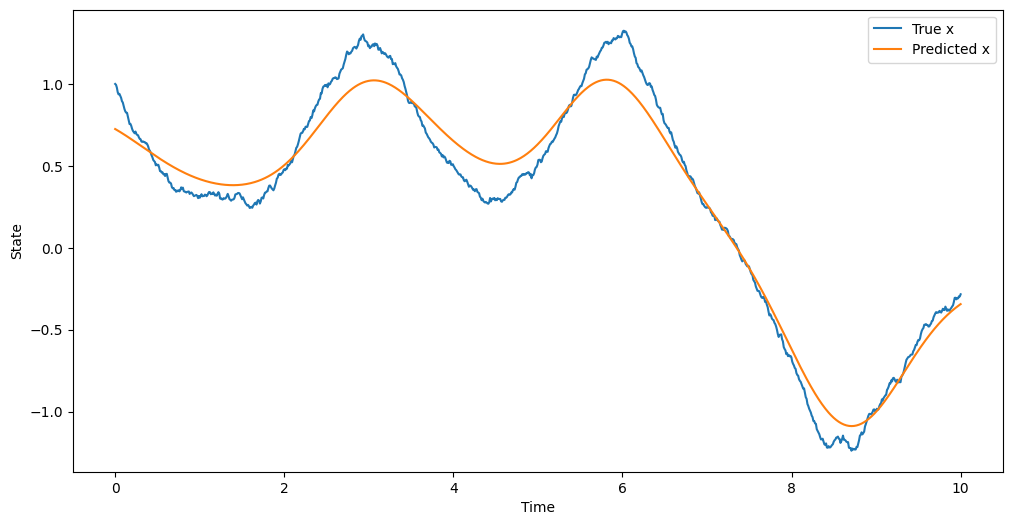

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(t_train, data[:, 0], label='True x')
plt.plot(t_test, predicted_states_test[:, 0], label='Predicted x')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.show()

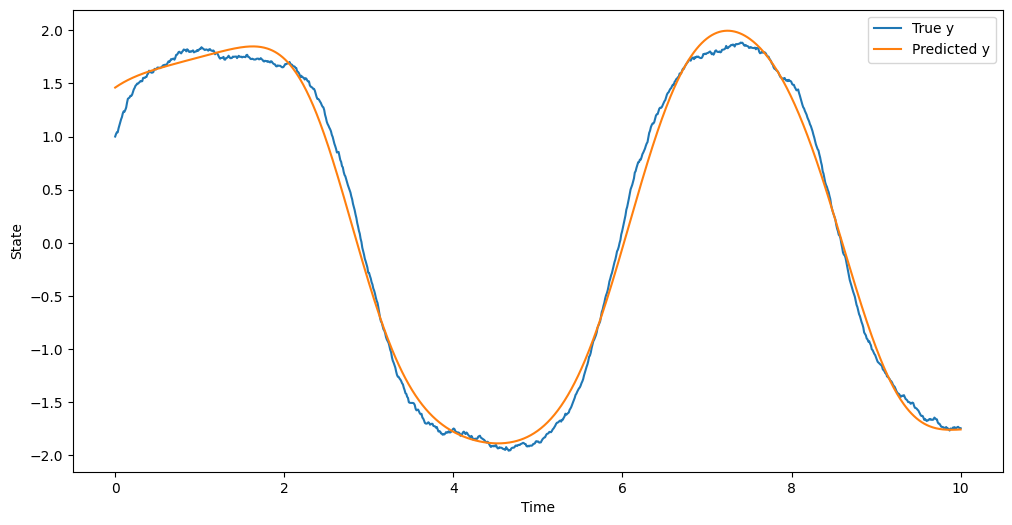

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(t_train, data[:, 1], label='True y')
plt.plot(t_test, predicted_states_test[:, 1], label='Predicted y')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.show()

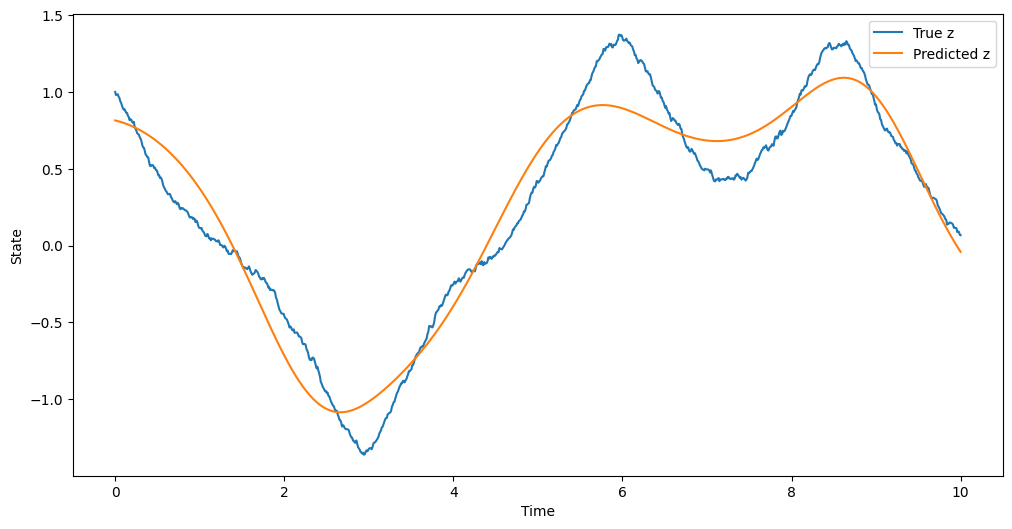

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(t_train, data[:, 2], label='True z')
plt.plot(t_test, predicted_states_test[:, 2], label='Predicted z')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.show()

## Visualisation

Combining the three trajectories, using plotly, we present the 3D model from actual data and predicted data

In [15]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=data[:, 0], y=data[:, 1], z=data[:, 2],
                           mode='lines', name='True Trajectory', line=dict(color='blue')))
fig.add_trace(go.Scatter3d(x=predicted_states_test[:, 0], y=predicted_states_test[:, 1], z=predicted_states_test[:, 2],
                           mode='lines', name='Predicted Trajectory', line=dict(color='red')))
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                  title='Rigid Body Dynamics',
                  width=800, height=600)
fig.show()

For future use, we export our model as .pt file

In [16]:
checkpoint_path='rbd.pt'
torch.save(model.state_dict(), checkpoint_path)